In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


In [2]:
print(f"TensorFlow version = {tf.__version__}\n")

TensorFlow version = 2.14.0



In [9]:
from pathlib import Path

! [ ! -d "/content/data" ] && gdown -O /content/kick-detector.zip "1FB_i3nP-XLt373hPuPUXzEZaS61zJVA-" &&  unzip -q /content/kick-detector.zip -d /content && rm /content/kick-detector.zip

base_path = Path("/content/data")


/content/data


<ipython-input-11-8e84cbd5a78f>:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "g." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['aX'], 'g.', label='x', linestyle='solid', marker=',')
<ipython-input-11-8e84cbd5a78f>:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "b." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['aY'], 'b.', label='y', linestyle='solid', marker=',')
<ipython-input-11-8e84cbd5a78f>:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['aZ'], 'r.', label='z', linestyle='solid', marker=',')


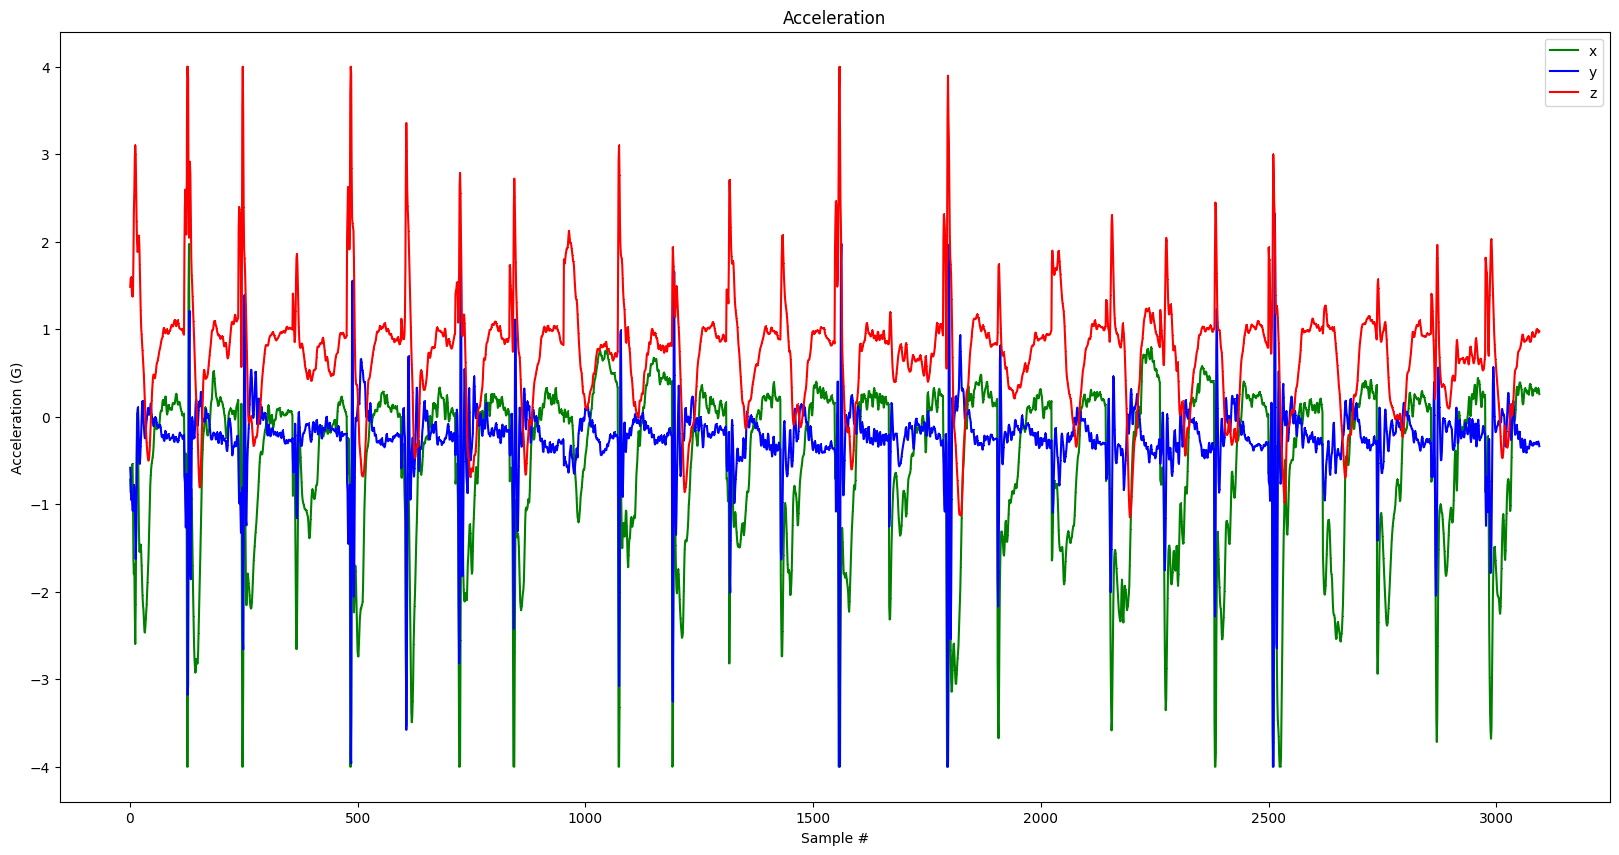

<ipython-input-11-8e84cbd5a78f>:18: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "g." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['gX'], 'g.', label='x', linestyle='solid', marker=',')
<ipython-input-11-8e84cbd5a78f>:19: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "b." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['gY'], 'b.', label='y', linestyle='solid', marker=',')
<ipython-input-11-8e84cbd5a78f>:20: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['gZ'], 'r.', label='z', linestyle='solid', marker=',')


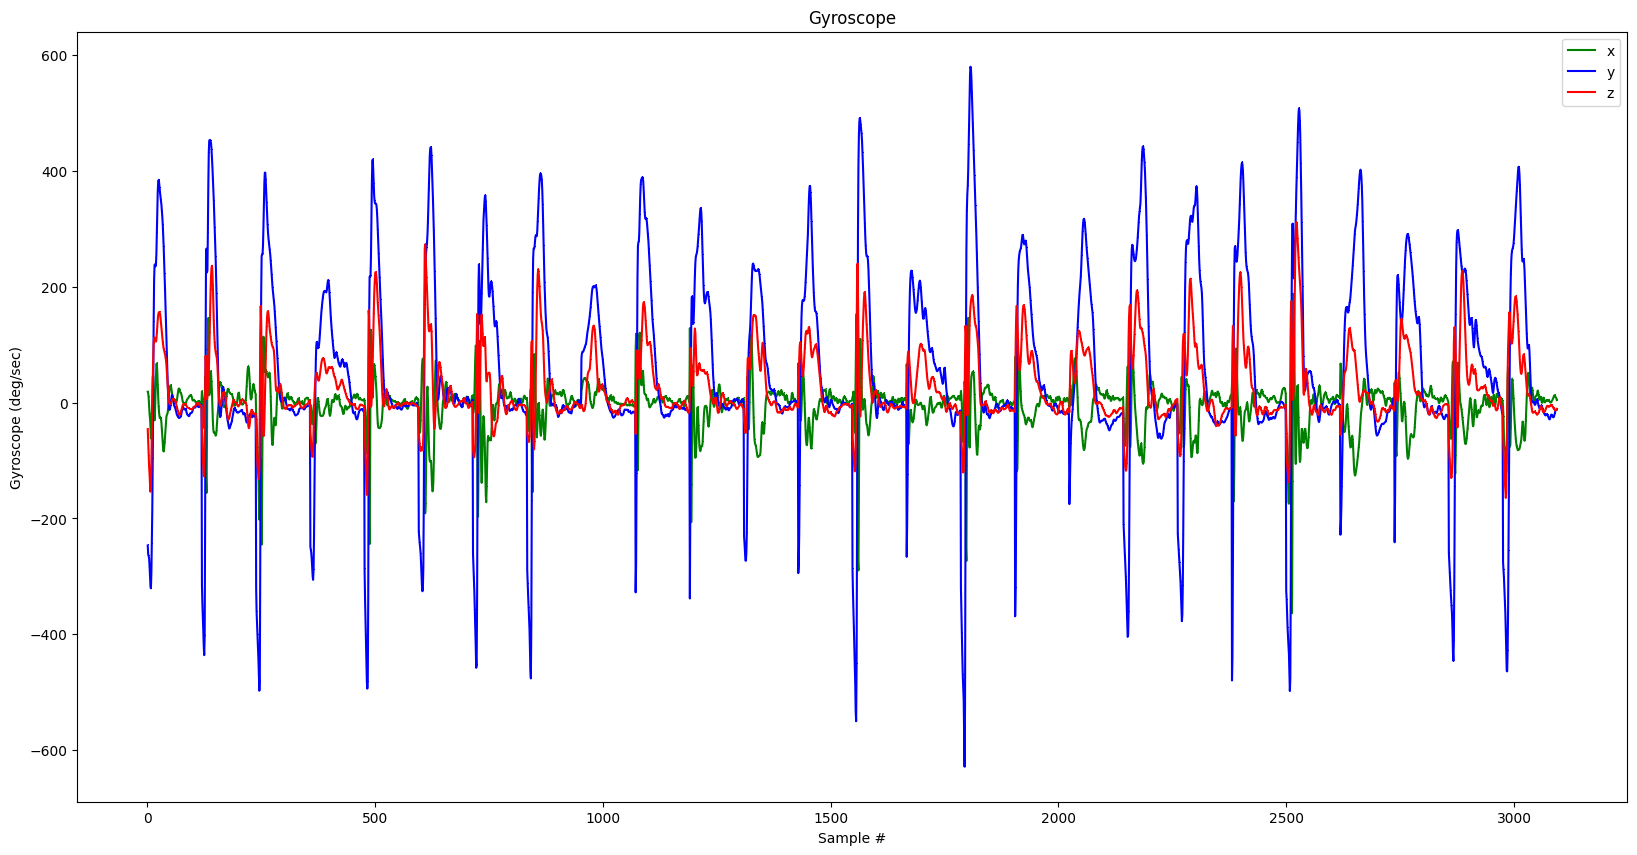

In [11]:
filename = "kick.csv"

df = pd.read_csv(str(base_path/filename))

index = range(1, len(df['aX']) + 1)

plt.rcParams["figure.figsize"] = (20,10)

plt.plot(index, df['aX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['aY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['aZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Acceleration")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (G)")
plt.legend()
plt.show()

plt.plot(index, df['gX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['gY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['gZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Gyroscope")
plt.xlabel("Sample #")
plt.ylabel("Gyroscope (deg/sec)")
plt.legend()
plt.show()

In [13]:
# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures that data is available for
GESTURES = [
    "kick",
    "no-kick"
]

SAMPLES_PER_GESTURE = 119

NUM_GESTURES = len(GESTURES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []

In [14]:
# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"Processing index {gesture_index} for gesture '{gesture}'.")

  output = ONE_HOT_ENCODED_GESTURES[gesture_index]

  df = pd.read_csv("./data/" + gesture + ".csv")

  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)

  print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")

  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_GESTURE):
      index = i * SAMPLES_PER_GESTURE + j
      # normalize the input data, between 0 to 1:
      # - acceleration is between: -4 to +4
      # - gyroscope is between: -2000 to +2000
      tensor += [
          (df['aX'][index] + 4) / 8,
          (df['aY'][index] + 4) / 8,
          (df['aZ'][index] + 4) / 8,
          (df['gX'][index] + 2000) / 4000,
          (df['gY'][index] + 2000) / 4000,
          (df['gZ'][index] + 2000) / 4000
      ]

    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")


Processing index 0 for gesture 'kick'.
	There are 26 recordings of the kick gesture.
Processing index 1 for gesture 'no-kick'.
	There are 69 recordings of the no-kick gesture.
Data set parsing and preparation complete.


In [15]:
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")


Data set randomization and splitting complete.


In [20]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(50, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(15, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(inputs_train, outputs_train, epochs=200, batch_size=1, validation_data=(inputs_validate, outputs_validate))


Epoch 1/200
57/57 [==============================] - 2s 19ms/step - loss: 0.2304 - mae: 0.4163 - val_loss: 0.2569 - val_mae: 0.5063
Epoch 2/200
57/57 [==============================] - 1s 9ms/step - loss: 0.2147 - mae: 0.4119 - val_loss: 0.2153 - val_mae: 0.4160
Epoch 3/200
57/57 [==============================] - 1s 14ms/step - loss: 0.2083 - mae: 0.4096 - val_loss: 0.2185 - val_mae: 0.3967
Epoch 4/200
57/57 [==============================] - 1s 13ms/step - loss: 0.2024 - mae: 0.3791 - val_loss: 0.2071 - val_mae: 0.4268
Epoch 5/200
57/57 [==============================] - 0s 5ms/step - loss: 0.2017 - mae: 0.3956 - val_loss: 0.2024 - val_mae: 0.4209
Epoch 6/200
57/57 [==============================] - 0s 6ms/step - loss: 0.1863 - mae: 0.3857 - val_loss: 0.1896 - val_mae: 0.3608
Epoch 7/200
57/57 [==============================] - 0s 3ms/step - loss: 0.1744 - mae: 0.3605 - val_loss: 0.1548 - val_mae: 0.3838
Epoch 8/200
57/57 [==============================] - 0s 4ms/step - loss: 0.1595 

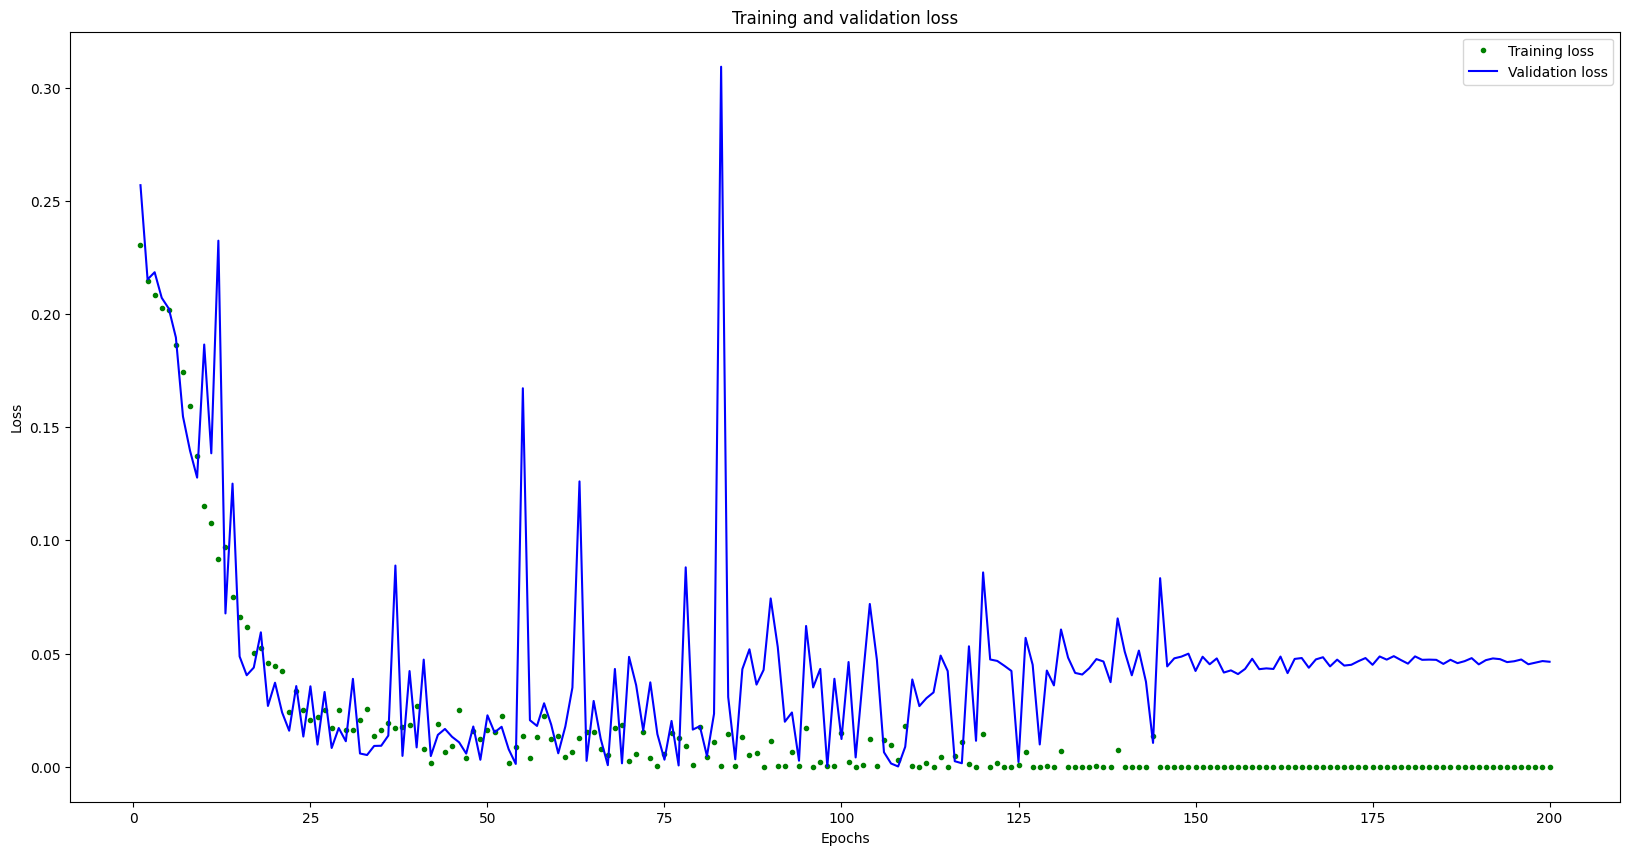

[20.0, 10.0]


In [21]:
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

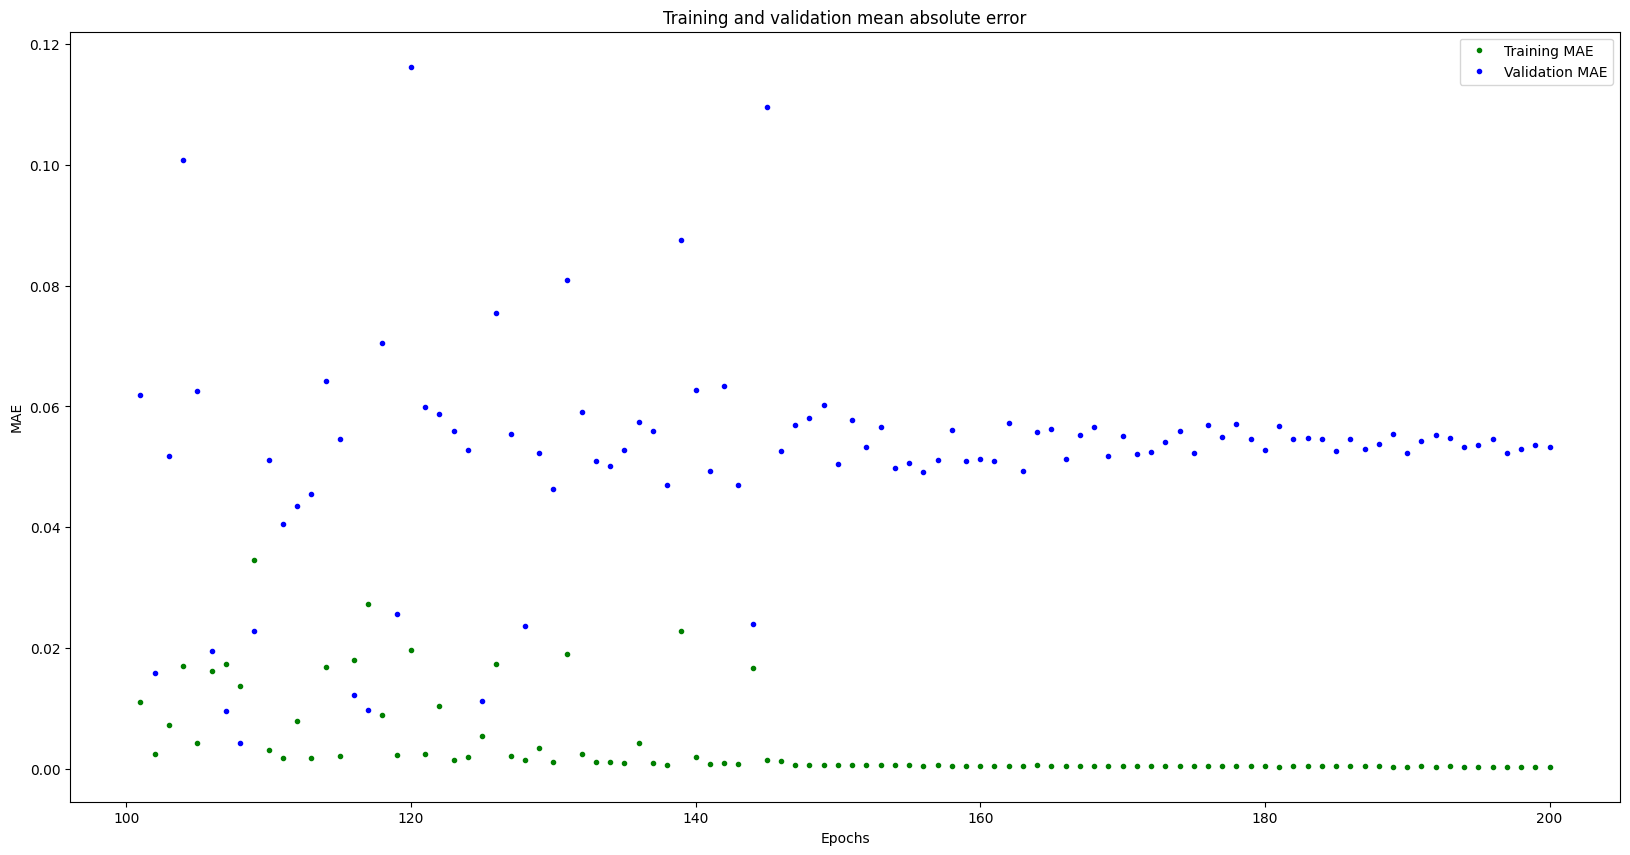

In [22]:
SKIP = 100

# graph of mean absolute error
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [24]:
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)


1/1 [==============================] - 0s 30ms/step
predictions =
 [[0.001 0.999]
 [0.025 0.975]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [1.    0.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [1.    0.   ]
 [1.    0.   ]
 [0.004 0.996]
 [0.004 0.996]
 [0.    1.   ]
 [1.    0.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]]
actual =
 [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Save the model to disk
# open("./content/model/kick_model.tflite", "wb").write(tflite_model)

# import os
# basic_model_size = os.path.getsize("./model/kick_model.tflite")
# print("Model is %d bytes" % basic_model_size)